# Setup

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from glob import glob
import datetime as dt
from tqdm import tqdm
from datetime import datetime

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

# GPS data

## Collect user pings from raw pings

Total pings in the unfiltered Louisiana Quadrant data:

Total unique users in the unfiltered Louisiana Quadrant data:

Total pings in the study region (all-time):

Total unique users in the study region & period:

## Extract HQ users

In [8]:
from pyspark.sql.functions import countDistinct, count
from pyspark.sql.functions import lit

def users_data_quality(rgn, date):
    # read the cleaned pings data
    path = str(QUADRANT) + '/'+ rgn.state + '/' + date.strftime('%Y/%m/%d')
    df = SP.read_parquet(path)
    # get time of day index (30 min bins)
    df = df.selectExpr('uid', 'explode(ts)').withColumn("TD", F.floor(F.col('col')/1800))
    # get uid, number of 30 min bins
    df = df.groupby('uid').agg(countDistinct('TD').alias('TD')).select('uid','TD').withColumn("DD",lit(date))
    return df

In [ ]:
def users_data_quality_multi(rgn, dates: pd.DatetimeIndex):
    print('Started:', dt.datetime.now().strftime('%b %-d, %-I:%-M:%-S %p'))
    df = users_data_quality(rgn, dates[0])
    dates = tqdm(dates[1:].date)
    for date in dates:
        dates.set_description(str(date))
        df = df.union(users_data_quality(rgn, date))
        
    return df

%time df_user = users_data_quality_multi(ida, pd.date_range('2021-08-01', '2021-11-30')) # t = 1h 40min

In [22]:
# # Store the df_user here
# outpath = U.mkdir(P.data + f'/users/{ida.name}/')
# try:
#     mk.spark.write(df_user, outpath, compress=True)
# except Exception as e:
#     print(date, e)

23/04/18 13:57:57 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


In [10]:
outpath = P.data + f'/users/{ida.name}/'
df_user = SP.session.read.load(outpath,format="parquet")

In [11]:
total_user = df_user.select(countDistinct('uid')).collect()[0][0]
total_user

6892756

In [12]:
user_mat = np.zeros((8, 5))
for i in range(8):
    tmp = df_user.filter(df_user.TD>= i*4).groupby('uid').agg(count('TD').alias('days'))
    for j in range(5):
        user_mat[i,j] =  tmp.filter(tmp.days>=j*5).count()

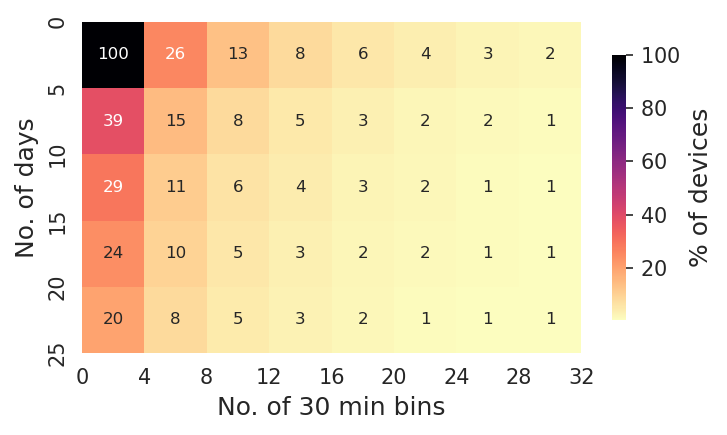

In [13]:
ax = U.plot(size=(5, 3), dpi=150)
ax = sns.heatmap(ax=ax, data=(user_mat/total_user*100).T, cmap='magma_r',
                 cbar_kws=dict(label='% of devices', shrink=0.8),
                 annot=True, fmt='.0f', annot_kws=dict(fontsize=8))
ax = U.plot(ax, xlab='No. of 30 min bins', ylab='No. of days')
ax.set_xticks(np.arange(0,8+1),np.arange(0,32+1,4))
ax.set_yticks(np.arange(0,5+1),np.arange(0,25+1,5))
cbar = ax.collections[0].colorbar
cbar.formatter.set_useMathText(True)

plt.tight_layout()
plt.savefig('../new_fig/data_quality.pdf')
plt.savefig('../new_fig/data_quality.png', dpi=300)

In [28]:
# The critieria is for us to confidently identify home areas, will keep 10% of users
i = 4
j = 15

tmp = df_user.filter(df_user.TD>= i).groupby('uid').agg(count('TD').alias('days'))
hq_users = tmp.filter(tmp.days>=j).select('uid').disp()

+--------------------+
|                 uid|
+--------------------+
|-9220594764880258060|
+--------------------+
only showing top 1 row



In [29]:
hq_users.select(countDistinct('uid')).collect()[0][0]

664895

## Filter HQ records

In [32]:
from pyspark.sql.functions import col

def filter_hq_pings(rgn, date, selected_users, max_error = 500):
    # read the cleaned pings data
    path = QUADRANT + rgn.state + '/' + date.strftime('%Y/%m/%d')
    df = SP.read_parquet(path)
    
    total_pings=df.select(F.size(LON).alias('n')).agg(F.sum('n')).collect()[0][0]
    # remove users who is not in hq users
    df = df.join(selected_users, ['uid'], 'leftsemi')
    
    # zip info of each record
    xyt_cols = [LON, LAT, TS]
    df = df.select('uid', F.arrays_zip(*xyt_cols, ERR).alias('X'))
    # filter pings within bounding box & remove erroneous pings (allow NaN)
    # minx, miny, maxx, maxy = rgn.bbox
    def filt(xyte):
        return list(zip(*[p[:3] for p in xyte 
                          if (p[3] == np.nan or p[3] <= max_error)]))
                          # and minx <= p[0] <= maxx and miny <= p[1] <= maxy]))
    df = df.select(UID, F.udf(filt, T.array(T.array(T.float)))('X').alias('X'))
    # remove users not having any ping filtered as above
    df = df.filter(F.size('X') > 0)
    # unzip the columns
    df = df.select(UID, *[df.X[i].alias(x) for i, x in enumerate(xyt_cols)])
    
    new_pings = df.select(F.size(LON).alias('n')).agg(F.sum('n')).collect()[0][0]
    
    print('Keep {:.1f}% of pings'.format(new_pings/total_pings*100)) # t = 24s
    
    return df

# %time p2 = filter_hq_pings(ida, dt.date(2021, 8, 15),hq_users).disp() # t = 11s

In [47]:
def filter_hq_pings_multi(rgn, dates: pd.DatetimeIndex, selected_users):
    print('Started:', dt.datetime.now().strftime('%b %-d, %-I:%-M:%-S %p'))
    dates = tqdm(dates.date)
    for date in dates:
        dates.set_description(str(date))
        outpath = U.mkdir(P.data + f'pings/{rgn.name}/') + str(date)
        if os.path.exists(outpath): continue
        try:
            df = filter_hq_pings(rgn, date, selected_users)
            mk.spark.write(df, outpath, compress=True)
        except Exception as e:
            print(date, e)
        
%time filter_hq_pings_multi(ida, pd.date_range('2021-08-01', '2021-11-30'),hq_users) # t = 1h 40min

Started: Feb 20, 9:37:40 AM


  0%|          | 0/122 [00:00<?, ?it/s]

Keep 95.0% of pings


CPU times: user 218 ms, sys: 58.5 ms, total: 277 ms
Wall time: 1min 44s


In [15]:
%%time
# t = 5min 40s
(SP.read_parquet(glob(P.data + f'/pings/{ida.name}/*'))
 .select(F.size(LAT).alias('n')).select(F.sum('n')).collect()[0][0])
# >> 8,855,704,569 pings

CPU times: user 105 ms, sys: 32.8 ms, total: 137 ms
Wall time: 38.8 s


8216268289

# Home detection

In [41]:
from clustering import MeanShift
import json
import warnings
from scipy import stats

In [42]:
pre_dates = pd.date_range('2021-08-01', '2021-08-21').date
post_dates = pd.date_range('2021-08-22', '2021-11-30').date

In [43]:
ms_radius = 200 # bandwidth radius for MeanShift clustering (in meters)
pre_min_pings = 5 # min pings per user in the before (pre) period
post_min_pings = 5 # "" in the after period per night

In [46]:
# MeanShift clustering parameters
ms_params = {'bin_seeding': True, 'min_bin_freq': 5, 'max_iter': 30, 'cluster_all': False}

In [ ]:
UID, LON, LAT, TS = 'uid', 'lon', 'lat', 'ts'

def filt(ts, start_hour, end_hour, kind='home'):
    if kind == 'home':
        return (ts >= end_hour * 3600) | (ts < start_hour * 3600)  # the last two conditions filter null records
    else:
        return (ts < end_hour * 3600) & (ts >= start_hour * 3600)  # the last two conditions filter null records

def new_bins(row):
    res = []
    x_sum = 0
    y_sum = 0
    n = 0
    i = -1
    for p in zip(row['lon'], row['lat'], row['flag']):
        if (p[0] is not None) and (p[1] is not None):
            if i != p[2]:
                if n > 0:
                    # var(lon) and var(lat)
                    res.append([x_sum/n, y_sum/n])
                i = p[2]
                x_sum = p[0]
                y_sum = p[1]
                n = 1 
            else:
                x_sum += p[0]
                y_sum += p[1]
                n+=1
            
    if n>0:
        res.append([x_sum/n, y_sum/n])
    return list(zip(*res))


def extract_bins(selected_users, dates: pd.DatetimeIndex,  start_hour=7, end_hour=21, kind = 'home'):
    path =  P.data + '/pings/Ida/' + dates[0].strftime('%Y-%m-%d')
    res = pd.read_parquet(path)
    res = pd.merge(selected_users, res, on='uid')

    # filter the pings, translate this to dataframe version
    res['keep_index'] = res[TS].apply(lambda x: filt(x, start_hour, end_hour, kind))

    res[LON] = res.apply(lambda x: x[LON][x['keep_index']], axis=1)
    res[LAT] = res.apply(lambda x: x[LAT][x['keep_index']], axis=1)
    
    # create the means
    res['flag'] = res[TS].apply(lambda x: (x//1800).astype(int))
    res['lon', 'lat'] = res.apply(lambda x: new_bins(x), axis=1)
    
    return res

def meanshift_top(X, Y, bw: float, kwargs: str):
    try:
        model = MeanShift(bandwidth=bw, **json.loads(kwargs))
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model.fit(np.vstack([X, Y]).T)
        return model.cluster_center # model.cluster_centers_[0].tolist() # use this when using vanilla meanshift
    except ValueError:
        return [np.nan, np.nan]
    
def dist_m2deg(dist, lat): # dist in meters
    return dist / (111.32 * 1000 * np.cos(lat * np.pi / 180))


def get_home_work_meanshift(df, LON='lon', LAT='lat', radius=ms_radius,
                            params=ms_params, n_jobs=40):
    res = []
    for _, r in tqdm(df.iterrows(), total=len(df)):
        x, y = r[LON], r[LAT]
        model = MeanShift(bandwidth=dist_m2deg(radius, np.mean(y) if y is not None else 0), **params)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                model.fit(np.vstack([x, y]).T)
            cx, cy = model.cluster_center#[0].tolist()
            res.append({UID: r[UID], LON: cx, LAT: cy, 'used_mean': False})
        except ValueError:
            cx, cy = x.mean(), y.mean()
            res.append({UID: r[UID], LON: cx, LAT: cy, 'used_mean': True})
    return pd.DataFrame(res).dropna()

In [48]:
selected_users = pd.read_parquet(P.data + "/selected_users.parquet")

In [50]:
import os

In [52]:
%%time
# a lot of time due to randomly getting stuck on some dates
# post_dates
dates = tqdm(pd.date_range('2021-08-01', '2021-11-30').date)
for d in dates:
    dates.set_description(str(d))
    try:
        outpath = P.data + f'/post_locs/Ida/' + str(d) + '.parquet'
        if os.path.exists(outpath): continue
        df_night = extract_bins(selected_users, [d], 7, 21, 'home')
        df_day = extract_bins(selected_users,[d], 7, 21, 'work')
        df_night.dropna(inplace = True)
        df_day.dropna(inplace = True)

        # drop empty rows
        df_night = df_night[df_night['lon'].apply(len) > 0]
        df_day = df_day[df_day['lon'].apply(len) > 0]
        
        df_night = get_home_work_meanshift(df_night, n_jobs=16)
        df_day = get_home_work_meanshift(df_day, n_jobs=16)
        df_night_day = pd.merge(left=df_night, right=df_day, on='uid', how = 'outer')
        df_night_day.to_parquet(outpath)
    except Exception as e:
        print(d, e)

2021-11-30: 100%|██████████| 122/122 [39:51:55<00:00, 1176.36s/it]

CPU times: total: 4d 13h 33min 51s
Wall time: 1d 15h 51min 55s


# Disp status

In [86]:
len(selected_users)

297082

In [7]:
import os
from haversine import haversine

In [8]:
pre_homes = pd.read_parquet(P.data + "/Ida_home.parquet")

In [9]:
haversine((45.7597, 4.8422), (48.8567, 2.3508), unit='mi')

243.71250609539814

In [12]:
UID, LON, LAT, TS = 'uid', 'lon', 'lat', 'ts'

In [13]:
for f in os.listdir(P.data + '/post_locs/Ida/'):
    post_homes = pd.read_parquet(P.data + '/post_locs/Ida/'+f)
    post_homes = pd.merge(pre_homes, post_homes, on='uid', how = "left")
    # calculate distance home to home and distance work to home
    post_homes['dist_home2home'] = post_homes.apply(lambda x: haversine((x['lat_x'], x['lon_x']), (x['lat'], x['lon']), unit='mi'), axis=1)
    post_homes['dist_work2home'] = post_homes.apply(lambda x: haversine((x['lat_y'], x['lon_y']), (x['lat'], x['lon']), unit='mi'), axis=1)            

    post_homes = post_homes[[UID, 'dist_home2home','dist_work2home']]

    post_homes.to_parquet(P.data+"/home_dists/"+f)

In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from glob import glob
import datetime as dt
from tqdm import tqdm
from datetime import datetime

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'

In [15]:
pre_homes = pd.read_parquet(P.data + '/Ida_home.parquet')

In [16]:
pre_homes = gpd.GeoDataFrame(pre_homes, geometry=gpd.points_from_xy(pre_homes['lon'], pre_homes['lat']), crs=CRS_DEG).dropna()

In [17]:
svi_tract = gpd.read_file(P.data + '/map/svi_tract.gpkg')

In [18]:
pre_homes = pre_homes.sjoin(svi_tract, predicate='within')

In [19]:
# post_homes = pd.concat([
#     pd.read_parquet(f).assign(date = f.split('\\')[-1].split('.')[0]) # "\\" for windows, "/" for other os
#     for f in tqdm(glob(P.data + '/home_dists/*.parquet'))
# ]).reset_index(drop=True)

# post_homes['date'] = pd.to_datetime(post_homes['date'])

# pre_homes = post_homes[post_homes['date']<= datetime.strptime('2021-08-21', '%Y-%m-%d')].reset_index()

# pre_homes = pre_homes.groupby("uid").agg({"dist_home2home": [np.nanmean, np.nanstd], \
#                              "dist_work2home": [np.nanmean, np.nanstd]})

# pre_homes = pre_homes.reset_index()
# pre_homes.columns = ['_'.join(col).strip() for col in pre_homes.columns.values]

# merged_home = pd.merge(pre_homes, post_homes, left_on='uid_', right_on='uid', how = 'left')

# merged_home['threshold_night'] = merged_home['dist_home2home_nanmean']+2*merged_home['dist_home2home_nanstd']
# merged_home['threshold_day'] = merged_home['dist_work2home_nanmean']+2*merged_home['dist_work2home_nanstd']
# merged_home['threshold_night'] = merged_home['threshold_night'].clip(lower=400/1609.344) # the minimum threshold is 400 m
# merged_home['threshold_day'] = merged_home['threshold_day'].clip(lower=400/1609.344)
# merged_home['displaced_night'] = merged_home['dist_home2home']>merged_home['threshold_night']
# merged_home['displaced_day'] = merged_home['dist_work2home']>merged_home['threshold_day']

# merged_home = merged_home.groupby('uid').agg({'displaced_night': list, 'displaced_day':list, 'date':list}).reset_index()

# merged_home.to_parquet(P.data+ '/displaced_by_halfday.parquet')

100%|██████████| 122/122 [00:03<00:00, 35.70it/s]


CPU times: total: 594 ms
Wall time: 5.23 s


In [ ]:
merged_home = pd.read_parquet(P.data+ '/displaced_by_halfday.parquet')

In [21]:
def get_displace_status(row, thres = 10):
    index = [dt.days for dt in (pd.to_datetime(row['date']) - datetime.strptime('2021-08-01', '%Y-%m-%d'))]
    displaced = [-1]*(2*(datetime.strptime('2021-12-01', '%Y-%m-%d') - datetime.strptime('2021-08-01', '%Y-%m-%d')).days)
    for i, disp_night, disp_day in zip(index, row['displaced_night'], row['displaced_day']):
        displaced[i*2] = 1 if disp_day else 0
        displaced[i*2 + 1] = 1 if disp_night else 0 
    
    current_state = 0
    for i in range(len(displaced)-thres+1):
        if(1-current_state == displaced[i]): # start of a new state
            count_left = sum([1 if j==1 else 0 for j in displaced[i:(i+thres)]])
            count_return = sum([1 if j==0 else 0 for j in displaced[i:(i+thres)]])
            if(count_left>thres*3/10):
                current_state = 1
                for j in range(i+1, i+thres*2//10):
                    displaced[j] = 1
            elif(count_return>=thres*8/10):
                current_state = 0
                for j in range(i+1, i+thres*8//10):
                    displaced[j] = 0
        
        displaced[i] = current_state
            
    for i in range(len(displaced)-thres+1, len(displaced)):
        displaced[i] = current_state
    
    return displaced

merged_home['disp_status'] = merged_home.apply(lambda row: get_displace_status(row), axis = 1)
merged_home['disp_status'] = merged_home['disp_status'].apply(lambda x: np.array(x))

In [23]:
def find_first(x,inds,target=1):
    for ind in inds:
        if x[ind]==1 and x[ind-1] == 0:
            return ind
    return -1

merged_home['disp_t'] = -1
merged_home['disp_t'] = merged_home['disp_status'].apply(lambda x: find_first(x, list(range(42,244))))

def find_return_t(row):
    if (row['disp_t']>0):
        for ind in range(row['disp_t'], len(row['disp_status'])):
            if row['disp_status'][ind]==0:
                return ind
    return -1

merged_home['returned_t'] = merged_home.apply(lambda x: find_return_t(x), axis = 1)
merged_home['returned'] = merged_home['returned_t'].apply(lambda x: x>0)
merged_home['duration'] = merged_home['returned_t'] - merged_home['disp_t']

merged_home.to_parquet(P.data+"/disp_by_uid.parquet")

# Evac destination

In [3]:
merged_home = pd.read_parquet(P.data + "/disp_by_uid.parquet")
disp_users = merged_home[(merged_home['disp_t']>0)]

# t = 6s
post_homes = pd.concat([
    pd.read_parquet(f).assign(date = f.split('\\')[-1].split('.')[0]) # "\\" for windows, "/" for other os
    for f in tqdm(glob(P.data + '/home_dists/*.parquet'))
]).reset_index(drop=True)

100%|██████████| 122/122 [00:03<00:00, 37.68it/s]


In [42]:
# index = [dt.days for dt in (pd.to_datetime(row['date']) - datetime.strptime('2021-08-01', '%Y-%m-%d'))]
# displaced = [-1]*(2*(datetime.strptime('2021-12-01', '%Y-%m-%d') - datetime.strptime('2021-08-01', '%Y-%m-%d')).days)
# for i, disp_night, disp_day in zip(index, row['displaced_night'], row['displaced_day']):
#       displaced[i*2] = 1 if disp_day else 0
#       displaced[i*2 + 1] = 1 if disp_night else 0 

In [4]:
# use the maximum home2home distance during the evacuated period as the evacuation distance, uid, dist
post_homes['date'] = pd.to_datetime(post_homes['date'])
res = []
for _, row in disp_users.iterrows():
    tmp = post_homes[post_homes['uid']==row['uid']]
    tmp = tmp[(tmp['date']-datetime.strptime('2021-08-01', '%Y-%m-%d')) >= dt.timedelta(days=int(row['disp_t']//2))]
    if row['returned']:
       tmp = tmp[(tmp['date']-datetime.strptime('2021-08-01', '%Y-%m-%d')) < dt.timedelta(days=int(row['returned_t']//2))]
    res.append(np.nanmax(tmp['dist_home2home']))
disp_users['dist'] = res

C:\Users\ALei\AppData\Local\Temp\ipykernel_49524\3829018099.py:9: RuntimeWarning: All-NaN axis encountered
  res.append(np.nanmax(tmp['dist_home2home']))
C:\Users\ALei\AppData\Local\Temp\ipykernel_49524\3829018099.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disp_users['dist'] = res


In [5]:
disp_users[['uid','dist']].to_parquet(P.data+"/Ida_dist.parquet")